In [242]:
import importlib
import pickle
import functools
from pathlib import Path

import pandas as pd
import seaborn as sns
import numpy as np
from itertools import product

from mapra import prep

sns.set_theme(style='white')

In [243]:
importlib.reload(prep)

# the directory to search
wd = Path('.').resolve().parent
(wd / 'plots').mkdir(parents=True, exist_ok=True)

data = prep.dataset(wd)
df = data.dataframe
df.columns

/home/quirin/PYTHON/mapra


/home/quirin/PYTHON/mapra/mapra/prep.py:29: RuntimeWarning: unexpected FASTA filename: /home/quirin/PYTHON/mapra/all_sequences_prothermdb.fasta
  warnings.warn('unexpected FASTA filename: ' + str(fasta), RuntimeWarning)


Index(['UniProt_ID', 'MUTATION', 'pH', 'MEASURE', 'METHOD', 'MUT_COUNT',
       'DELTA', 'dtemp', 'ddg', 'h2o', 'DATASET', 'LENGTH', 'REPEATS'],
      dtype='object')

### extract embeddings for the SAVs from H5
the variants are labelled without the original residue here:
`P224R` in the dataframe becomes `224R` in the `.h5`.

In [244]:
a = False
if a:
    import h5py
    import numpy as np

    mbeds = dict()
    with h5py.File(wd / 'all_sequences_prothermdb_HALF.h5', 'r') as f:
        for i, key in enumerate(f.keys()):
            pieces = key.split('_')
            uniprot_id, variant = pieces[0], '_'.join(pieces[1:])
            positions = [int(p[:-1]) - 1 for p in pieces[1:]]

            if uniprot_id not in mbeds:
                mbeds[uniprot_id] = dict()
            if not variant:
                mbeds[uniprot_id]['wt'] = np.array(f[key])
            else:
                mbeds[uniprot_id][variant] = np.array(f[key])[positions, :]
    print(f'fetched {sum(len(v) for v in mbeds.values())} embeddings for {len(mbeds)} proteins')

### calculate paired distances for all embeddings

In [282]:
from sklearn.metrics.pairwise import paired_distances

## re-extract embedding data
extend = 5
data.read_mbeds(wd, extend=extend)

In [283]:
# fetch embedding data
mbeds = data.mbeds

pdists = dict()
metrics = ['euclidean', 'cosine', 'manhattan']

for uniprot_id, d in mbeds.items():
    wt = d.pop('wt')
    pdists[uniprot_id] = dict()
    for variant, ar in d.items():
        positions = [int(p[:-1]) - 1 for p in variant.split('_')]

        # extend to neighbourhood
        positions = sorted(set([c for ran in [list(range(
            max(0, p - extend), min(len(wt), p + extend + 1)))
            for p in positions] for c in ran]))

        pdists[uniprot_id][variant] = {m: sum(
            paired_distances(wt[positions, :], ar, metric=m)) for m in metrics}
    d['wt'] = wt

### transfer paired distances to the dataframe
done: use different dataframes: `reduced=True`, remerged, repeats, gaussian
done: correlation ausrechnen
done: die anderen dataframes ausprobieren
die umgebung miteinbeziehen
labels auf 0-1, 1-10, 10+


In [284]:
df = data.dataframe_abbrev(reduced=True)  # all records are their own line
# df = data.dataframe_remerged(reduced=True)
# df = data.dataframe_repeats_avg(reduced=True)
# df = data.dataframe_gaussian_avg(reduced=True)

for m in metrics:
    df[m] = df.apply(lambda gdf: pdists.get(
        gdf.UniProt_ID, dict()).get(gdf.MUTATION, dict()).get(m, 0), axis=1)
df

,UniProt_ID,MUTATION,pH,MEASURE,METHOD,MUT_COUNT,DELTA,dtemp,ddg,h2o,DATASET,LENGTH,REPEATS,euclidean,cosine,manhattan
0,A0A060GYS1,22R,7.5,fluorescence,Thermal,1,dtemp,9.9,NaN,NaN,reduced_set,333,1,15.085589,0.335350,372.068618
1,A0A060GYS1,224R,7.5,fluorescence,Thermal,1,dtemp,2.3,NaN,NaN,reduced_set,333,1,15.613937,0.500057,385.406176
2,A0A410ZNC6,341S,7.5,Fluorescence,Thermal,1,dtemp,3.6,NaN,NaN,reduced_set,458,1,10.538955,0.222339,259.678638
3,A0A410ZNC6,184L,7.5,Fluorescence,Thermal,1,dtemp,1.0,NaN,NaN,reduced_set,458,1,9.620778,0.197083,237.023623
4,A0A410ZNC6,184L_250L_341S,7.5,Fluorescence,Thermal,3,dtemp,5.6,NaN,NaN,reduced_set,458,1,37.410561,0.907052,925.198382
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14593,R9S082,15F,7.8,CD,Urea,1,h2o,NaN,NaN,-0.6,reduced_set,154,3,14.245211,0.333747,348.603563
14594,R9S082,15F,7.8,CD,Urea,1,h2o,NaN,NaN,-1.1,reduced_set,154,3,14.245211,0.333747,348.603563
14595,R9S082,8F,7.8,CD,Urea,1,h2o,NaN,NaN,-0.9,reduced_set,154,3,12.589545,0.243443,308.548258
14596,R9S082,8F,7.8,CD,Urea,1,h2o,NaN,NaN,-1.1,reduced_set,154,3,12.589545,0.243443,308.548258


### plot correlations

In [285]:
def flip(gdf):
    if gdf.change < 0:
        gdf.mbed_dist *= -1
    return gdf

In [289]:
dfc = df.loc[:, data.order + metrics].melt(
    id_vars=data.order, value_vars=metrics,
    var_name='mbed_metric', value_name='mbed_dist').melt(
    id_vars=['mbed_metric', 'mbed_dist'], value_vars=data.order,
    var_name='delta', value_name='change')
dfc = dfc[~dfc.change.isna()].reset_index(drop=True)  # drop all the NaN lines. it's ok why they were there
mod = None
if mod:
    # dfc.change = dfc.change.abs() # make all changes positive
    # dfc = dfc.loc[dfc.change > 0]
    dfc = dfc.apply(flip, axis=1)
dfc

,mbed_metric,mbed_dist,delta,change
0,euclidean,15.085589,dtemp,9.9
1,euclidean,15.613937,dtemp,2.3
2,euclidean,10.538955,dtemp,3.6
3,euclidean,9.620778,dtemp,1.0
4,euclidean,37.410561,dtemp,5.6
...,...,...,...,...
36238,manhattan,348.603563,h2o,-0.6
36239,manhattan,348.603563,h2o,-1.1
36240,manhattan,308.548258,h2o,-0.9
36241,manhattan,308.548258,h2o,-1.1


In [290]:
# calculate Pearson correlation coefficient
covs = dict()
for d, m in product(data.order, metrics):
    covs[d, m] = np.corrcoef(
        dfc.loc[(dfc.delta == d) & (dfc.mbed_metric == m),
                ['mbed_dist', 'change']], rowvar=False)[0, 1]
covs


{('dtemp', 'euclidean'): 0.1614918882011973,
 ('dtemp', 'cosine'): 0.15602155274410023,
 ('dtemp', 'manhattan'): 0.16036584848578045,
 ('ddg', 'euclidean'): 0.08874497888160343,
 ('ddg', 'cosine'): 0.058075600965214136,
 ('ddg', 'manhattan'): 0.0863080749046034,
 ('h2o', 'euclidean'): 0.1746259309896551,
 ('h2o', 'cosine'): 0.14819674361071494,
 ('h2o', 'manhattan'): 0.17580400203167162}

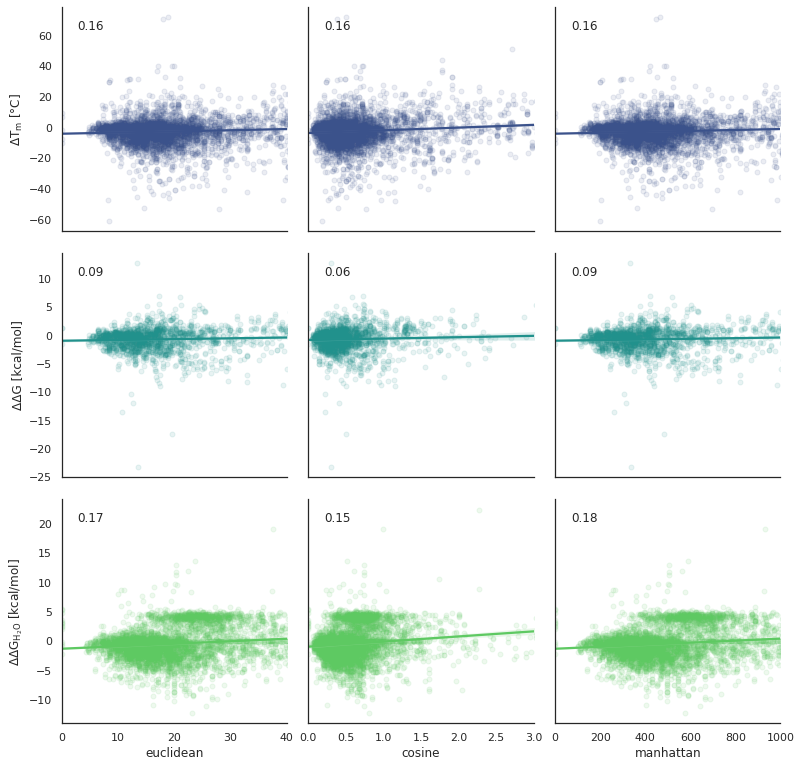

In [291]:
# create a plot
g = sns.lmplot(data=dfc,
               x='mbed_dist', y='change',
               hue='delta', palette='viridis',
               sharex=False, sharey='row',
               col='mbed_metric', col_order=metrics,
               row='delta', row_order=data.order,
               scatter_kws={'s': 25, 'alpha': .1},
               height=3.6, aspect=1, ci=95, order=1, #fit_reg=False,
               )

for (d, m), ax in g.axes_dict.items():
    # ax.axline((0,0), slope=1, color='.5', lw=.7)
    pearson_corr = np.corrcoef(dfc.loc[(dfc.delta == d) & (dfc.mbed_metric == m),
                                       ['mbed_dist', 'change']], rowvar=False)[0, 1]
    ax.text(.07,.9, f'{pearson_corr:.2f}', transform=ax.transAxes)
for i, ax in enumerate(g.axes[2,]):
    ax.set_xlabel(metrics[i])
for i, ax in enumerate(g.axes[:, 0]):
    ax.set_ylabel(data.tex_lookup[data.order[i]] + [' [°C]', ' [kcal/mol]', ' [kcal/mol]'][i])
    ax.set_xlim(-40 if mod else 0, 40)
for ax in g.axes[:, 1]:
    ax.set_xlim(-3 if mod else 0, 3)
for ax in g.axes[:, 2]:
    ax.set_xlim(-1000 if mod else 0, 1000)
for ax in g.axes.flatten()[:6]:
    ax.set_xticklabels([])
for ax in g.axes.flatten():
    ax.set_title('')
g.fig.subplots_adjust(hspace=.1)
g.savefig(wd / 'plots' / f'5_neighbors_pearson_sum_{mod if mod else "none"}_ci95.png', dpi=300)


In [292]:
# try training already
change_metrics_lookup = {m: i for i, m in enumerate(data.order)}
dfc['delta_code'] = dfc.delta.apply(change_metrics_lookup.get)
mbed_metric_lookup = {m: i for i, m in enumerate(metrics)}
dfc['mbed_metric_code'] = dfc.mbed_metric.apply(mbed_metric_lookup.get)
print(dfc.columns)

df_fit = dfc[['delta_code', 'mbed_metric_code', 'mbed_dist', 'change']]
df_fit

Index(['mbed_metric', 'mbed_dist', 'delta', 'change', 'delta_code',
       'mbed_metric_code'],
      dtype='object')


,delta_code,mbed_metric_code,mbed_dist,change
0,0,0,15.085589,9.9
1,0,0,15.613937,2.3
2,0,0,10.538955,3.6
3,0,0,9.620778,1.0
4,0,0,37.410561,5.6
...,...,...,...,...
36238,2,2,348.603563,-0.6
36239,2,2,348.603563,-1.1
36240,2,2,308.548258,-0.9
36241,2,2,308.548258,-1.1


In [293]:
from sklearn import linear_model

lm = linear_model.LinearRegression()
lm.fit(dfc[['delta_code', 'mbed_metric_code', 'mbed_dist']], dfc['change'])
lm.coef_

array([ 0.96358922, -0.46296958,  0.00184424])

### train models
TODO: train models on `data.dataframe_remerged(reduced=True)`
then find out how to merge the `lm.coef_` and apply that to build a single compound model?

In [11]:
# training models separately
models = dict()
for c in change_metrics:
    for m in metrics:
        dfcm = df.loc[df.DELTA == c, [c, m]]
        break
dfcm[c]
df[['dtemp', 'ddg', 'h2o']]

,dtemp,ddg,h2o
0,9.9,NaN,NaN
1,2.3,NaN,NaN
2,3.6,NaN,NaN
3,1.0,NaN,NaN
4,5.6,NaN,NaN
...,...,...,...
14593,NaN,NaN,-0.6
14594,NaN,NaN,-1.1
14595,NaN,NaN,-0.9
14596,NaN,NaN,-1.1


In [12]:
from sklearn import linear_model

lm = linear_model.LinearRegression()
TODO
the
other
way
round! predict from embedding
lm.fit(df[['dtemp', 'ddg', 'h2o']], df[metrics])  # TODO the other way round! predict from embedding
# lm.fit(dfcm[c], dfcm[m])
# lm.fit(dt[:,0].reshape(-1,1), dt[:,1].reshape(-1,1))
lm.coef_

SyntaxError: invalid syntax (<ipython-input-12-d4fbcde152f8>, line 8)

In [ ]:
from sklearn import preprocessing

le = preprocessing.LabelEncoder()
le.fit(dt[:, 1].reshape(-1, 1))
len(le.classes_)